## Разведочный анализ данных (EDA)

In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from numpy import sqrt
from scipy.stats import norm, ttest_ind
import math as mt

In [2]:
ds_control = pd.read_csv('control_data.csv')

Рассмотрим имеющиеся в нашем распоряжении данные:

In [3]:
ds_control.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0


Составим интересующие нас метрики по имеющимся данным:

In [4]:
ds_control['CTP'] = round(ds_control['Clicks']/ds_control['Pageviews'], 3)
ds_control['GC'] = round(ds_control['Enrollments']/ds_control['Clicks'], 3)
ds_control['Retention'] = round(ds_control['Payments']/ds_control['Enrollments'], 3)
ds_control['NC'] = round(ds_control['Payments']/ds_control['Clicks'], 3)
ds_control['PP'] = round(ds_control['Payments']/ds_control['Pageviews'], 3)
ds_control.head()

,Date,Pageviews,Clicks,Enrollments,Payments,CTP,GC,Retention,NC,PP
0,"Sat, Oct 11",7723,687,134.0,70.0,0.089,0.195,0.522,0.102,0.009
1,"Sun, Oct 12",9102,779,147.0,70.0,0.086,0.189,0.476,0.090,0.008
2,"Mon, Oct 13",10511,909,167.0,95.0,0.086,0.184,0.569,0.105,0.009
3,"Tue, Oct 14",9871,836,156.0,105.0,0.085,0.187,0.673,0.126,0.011
4,"Wed, Oct 15",10014,837,163.0,64.0,0.084,0.195,0.393,0.076,0.006


Проведем разведочный анализ данных. 
Для этого воспользуемся библиотекой pandas_profiling, 
которая позволяет получить все необходимые для первичного анализа сведения в формате HTML-отчета:
1. тип данных в каждой колонке;
2. пропущенные и уникальные значения (количество и процент);
3. описательные статистики: квартили, медиану, 
    межквартильный размах, среднее, моду, абсолютное и 
    относительное стандартное отклонение, медианное абсолютное отклонение, 
    коэффициенты асимметрии и эксцесса;
4. графики распределений в виде гистограммы частот;
5. корреляции между значениями (Пирсона, Спирмена и Кендалла);
6. матрица пропущенных значений.

In [5]:
import pandas_profiling
pandas_profiling.ProfileReport(ds_control)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Выводы


<p>
Благодаря отчету, полученному с помощью pandas_profiling можно сделат несколько полезных для нас выводов:
    <br>
    <br>
    1. Глядя на описательные статистики и гистограммы видно, что наши данные (Date, Pageviews, Clicks, Enrollments,Payments) не содержат выбросов. Поэтому во время проведения AB-теста их ждать не стоит, что облегчает нам задачу. 
    <br>
    <br>
    2. Гистограммы частот говорят о том, что половина распределений наших данных принадлежат к классу нормальных (Pageviews, Enrollments), а распределение другой половины напоминает раномерное (Clicks, Payments).  
    <br>
    <br>
    3. Глядя на построенную матрицу корреляций, а также на специальные сообщения (allerts) замечаем, что многие из наших 
    данных сильно корреляируют друг с другом. Например число кликов по кнопке с регистрацией на пробный период (Clicks) зависит от числа просмотров страницы курса (Pageviews), число платящих пользователей (Payments) зависит от числа регистраций на курс (Enrollements). Стоит отметить, что хотя наличие корреляции не влияет на алгоритм проведения AB-теста, но полученные зависимости расширяют наши знания о предметной области.
    <br>
    <br>
    4.Глядя на матрицу пропущенных значений, видим, что они у нас имеются, причем носят систематический характер и их 
    довольно много (37.8% значений отсутствует у Enrollements и Payments, поэтому столько же пропусков имеют и наши метрики (GC, Retention, NC, PTP), которые получаются из них простыми арифметическими преобразованиями. Это необходимо учитывать при проведении AB-теста.
</p>

# Масштабирование размера выборки

Перед проведением теста нужно определить эффективный разме рвыборки в зависимости от ожидаемой разности конверсий контрольной и рабочей группы $$d = 0.01$$ и в зависимости от **уровня значимости** $$\alpha = 0.05$$ и от **статистической мощности** $$\beta = 0.2$$ для которых мы принимаем стандартные значения.

Перед определением эффективного размера выборки определим **BaseLine**.

## Определение BaseLine

Воспользуемся информацией от разработчиков курса по характеристикам их ежедневного трафика.

In [6]:
baseline = {"Cookies": [40000],"Clicks":[3200],"Enrollments":[660],"CTP":[0.08],"GConversion":[0.20625],
           "Retention":[0.53],"NConversion":[0.109313]}

baseline = pd.DataFrame(baseline)
baseline.T.rename(columns={0:'Приближенные значения характеристик за день'})

,Приближенные значения характеристик за день
Cookies,40000.000000
Clicks,3200.000000
Enrollments,660.000000
CTP,0.080000
GConversion,0.206250
Retention,0.530000
NConversion,0.109313


Так как нам нужно будет найти оценку стандартного отклонения по выборке, нельзя взять все 40 000 уникальных пользователей за день, ведь при увеличении вариативности метрики труднее достичь желаемого результата. Для нахождения оценки СКО мы предположим, что выборка составляет 5000. Тогда определим смашстаблированный **BaseLine**.

In [7]:
baseline.Cookies = 5000
baseline.Clicks = baseline.Clicks * (baseline.Cookies / 40000)
baseline.Enrollments = baseline.Enrollments * (baseline.Cookies / 40000)
baseline.T.rename(columns={0:'Приближенные значения характеристик за день'})

,Приближенные значения характеристик за день
Cookies,5000.000000
Clicks,400.000000
Enrollments,82.500000
CTP,0.080000
GConversion,0.206250
Retention,0.530000
NConversion,0.109313


## Нахождение оценки дисперсии

Найдем оценку дисперсию для расчета Z - статистики. Возьмем конверсию за вероятность **p** и для нахождения дисперсии по выборке размером **n** воспользуемся биномиальным распределением.
Расчитаем дисперсию по формуле $$SD = \sqrt{\frac{(p) * (1-p)}{n}}$$

In [8]:
def GetSD(p, n):
    if(p > 1):
        return np.nan
    return sqrt(p * (1 - p) / n)

In [9]:
n = baseline.Clicks.values[0]
baseline = baseline.T
baseline['SD'] = baseline.apply(lambda x: GetSD(x.values[0], n), axis = 1) 
baseline['d'] = [np.nan, np.nan, np.nan, np.nan, 0.01, 0.01, 0.0075]

In [10]:
baseline = baseline.T
baseline.T.rename(columns={0:'Приближенные значения характеристик за день'}).style.format("{:.4f}")

,Приближенные значения характеристик за день,SD,d
Cookies,5000.0000,nan,nan
Clicks,400.0000,nan,nan
Enrollments,82.5000,nan,nan
CTP,0.0800,0.0136,nan
GConversion,0.2062,0.0202,0.0100
Retention,0.5300,0.0250,0.0100
NConversion,0.1093,0.0156,0.0075


## Нахождение эффективной выборки 

На данном этапе определим эффективный размер выборки для изменения на **d** каждой из конверсии с учетом уровня значимости (0.05) и статистической мощности (0.2).

In [11]:
alpha = 0.05
beta = 0.2

Будем определеять минимальный размер выборки с помощью **Z** - статистики, для которой и находили оценку СКО, по следующим формулам:
$$n = \frac{(Z_{1 - \frac{\alpha}{2}} * sd_1 + Z_{1 - \beta} * sd_2)^2}{d}$$
где 
$$sd1 = \sqrt{2*p*(1-p)}$$


$$sd2 = \sqrt{p * (1 - p) + (p+d)*(1 - (p+d))}$$

In [12]:

def GetZScore(alpha):
    return norm.ppf(alpha)


def GetSDS(p, d = 0.01):
    if(np.isnan(d)):
        return np.nan
    
    sd1 = sqrt(2 * p * (1 - p))
    sd2 = sqrt(p * (1 - p) + (p + d) * (1 - (p + d))) 
    return [sd1, sd2]


def GetEffectiveSize(sds, alpha = 0.05, beta = 0.2, d = 0.01):
    if(np.isnan(d)):
        return np.nan
    
    n = pow((GetZScore(1 - alpha / 2) * sds[0] + GetZScore(1 - beta) * sds[1]), 2) / pow(d, 2)
    return round(n)



In [13]:
baseline = baseline.T.rename(columns = {0:'Val'})


In [14]:
baseline['SDS'] = baseline.apply(lambda x: GetSDS(x.Val, x.d), axis = 1)



In [15]:
baseline


,Val,SD,d,SDS
Cookies,5000.000000,NaN,NaN,NaN
Clicks,400.000000,NaN,NaN,NaN
Enrollments,82.500000,NaN,NaN,NaN
CTP,0.080000,0.013565,NaN,NaN
GConversion,0.206250,0.020231,0.0100,"[0.5722078949123299, 0.5772320807093105]"
Retention,0.530000,0.024955,0.0100,"[0.7058328414008518, 0.7053367989832943]"
NConversion,0.109313,0.015602,0.0075,"[0.4412792042029626, 0.4478073146588832]"


In [16]:
baseline['EffectiveSize'] = baseline.apply(lambda x: GetEffectiveSize(x.SDS, d = x.d), axis = 1)
baseline = baseline.drop(['SDS'], axis = 1)

In [17]:
baseline = baseline.T
baseline.T

,Val,SD,d,EffectiveSize
Cookies,5000.000000,NaN,NaN,NaN
Clicks,400.000000,NaN,NaN,NaN
Enrollments,82.500000,NaN,NaN,NaN
CTP,0.080000,0.013565,NaN,NaN
GConversion,0.206250,0.020231,0.0100,25835.0
Retention,0.530000,0.024955,0.0100,39087.0
NConversion,0.109313,0.015602,0.0075,27413.0


Итак, мы получили, что эффективный размер выборки для **Gross Conversion** составляет 25 835 человека - столько уникальных пользователей должны зарегистрироваться после нажатия в день. <br>
Так как это слишком много, отмасштабируем до нашей выборки в 5000 за день на группу и допустим, лишь 400 из них зарегестрируется, то есть 400/5000 = 0.08. Тогда смашстабируем каждую конверсию: 

In [18]:
baseline = baseline.T
baseline.EffectiveSize = baseline.EffectiveSize / 0.08  / [0, 0, 0, 0, 1, 0.20625, 1] * 2

In [19]:
baseline

,Val,SD,d,EffectiveSize
Cookies,5000.000000,NaN,NaN,NaN
Clicks,400.000000,NaN,NaN,NaN
Enrollments,82.500000,NaN,NaN,NaN
CTP,0.080000,0.013565,NaN,NaN
GConversion,0.206250,0.020231,0.0100,6.458750e+05
Retention,0.530000,0.024955,0.0100,4.737818e+06
NConversion,0.109313,0.015602,0.0075,6.853250e+05


Размер выборки для изменения конверсии Retention на 0.0075 4.7 миллиона, что очень много и мы очень долго будем набирать такой размер выборки.<br>
Для наших нужд возьмем размер выборки для **Net Conversion**, так как это больше чем для **Gross Conversion** и данное количество пользователей мы сможем собрать за три недели.

# Анализ данных теста

In [20]:
control=pd.read_csv("control_data.csv")
experiment=pd.read_csv("experiment_data.csv")
print("Контрольная группа:")
display(control.describe())
print("\n\nРабочая группа:")
display(experiment.describe())

Контрольная группа:


,Pageviews,Clicks,Enrollments,Payments
count,37.000000,37.000000,23.000000,23.000000
mean,9339.000000,766.972973,164.565217,88.391304
std,740.239563,68.286767,29.977000,20.650202
min,7434.000000,632.000000,110.000000,56.000000
25%,8896.000000,708.000000,146.500000,70.000000
50%,9420.000000,759.000000,162.000000,91.000000
75%,9871.000000,825.000000,175.000000,102.500000
max,10667.000000,909.000000,233.000000,128.000000




Рабочая группа:


,Pageviews,Clicks,Enrollments,Payments
count,37.000000,37.000000,23.000000,23.000000
mean,9315.135135,765.540541,148.826087,84.565217
std,708.070781,64.578374,33.234227,23.060841
min,7664.000000,642.000000,94.000000,34.000000
25%,8881.000000,722.000000,127.000000,69.000000
50%,9359.000000,770.000000,142.000000,91.000000
75%,9737.000000,827.000000,172.000000,99.000000
max,10551.000000,884.000000,213.000000,123.000000


Как можно заметить, количество данных по просмотрам и кликам больше, чем по регистрация и оплатам. 
Так как последние два столбца имеют особенность в том, что они содержат в себе данные за будущий двухнедельный период.<br>
Как можно понять, набор данных содержит в себе показатели за чуть больше чем **5** недель, из которых для регистраций и платежей есть данные только за **3** недели. Как раз столько времени и нужно для накопления эффективного размера контрольной и экспериметнальной выборки. <br>
Далее посмотрим, набрался ли требуемый размер выборки

In [21]:
pageviews_control = control['Pageviews'].sum()
pageviews_experiment = experiment['Pageviews'].sum()
pageviews_total = pageviews_control + pageviews_experiment

print(f"\tТребуемый размер на одну группу {baseline.loc['NConversion'].EffectiveSize // 2}\n\
        Размер контрольной выборки {pageviews_control}\n\
        Размер экспериментальной выборки {pageviews_experiment}\n\
        Суммарный размер {pageviews_total}")

	Требуемый размер на одну группу 342662.0
        Размер контрольной выборки 345543
        Размер экспериментальной выборки 344660
        Суммарный размер 690203


Как видим, требования по размеру выборки выполнены и можем идти дальше

Далее определим, является ли разница в размерах случайной.
Скажем, что распределение по выборкам происходит по Биномиальному случайному распределению с вероятностью **p = 0.5**.
Тогда размер выборки будет являться случайной величиной распределенной по Биномиальному распределению.
Через Центральную Предельную Теорему перейдем от биномиального распределениия к нормальному распределению: $$ X \sim N(\mu = p, \sigma = \sqrt{\frac{p(1-p)}{n}})$$
Теперь можно найти доверительный инвервал вероятности принадлежности к одной из выборок. Нам важно знать, значительно ли отличается отношение размера выборки в группе от общего числа участников от **0.5**
Найедм погрешность как $$ME = Z_{1-\frac{\alpha}{2}}SD$$
Далее найдем доверительный интервал с уровнем значимости 0.05 как
$$CI = [p - ME; p + ME]$$

In [22]:
p = 0.5
alpha = 0.05
p_hat = round(pageviews_control / (pageviews_total), 4)
sd = np.sqrt(p * (1 - p) / (pageviews_total))
ME = round(GetZScore(1 - (alpha / 2)) * sd, 4)
print ("Доверителный интервал принимает значения от ",p - ME," до ",p + ME," Наше распределение для контрольной выборки равное",p_hat,"лежит внутри доверительного интервала?")
print()
p_hat = round(pageviews_experiment / (pageviews_total), 4)
print ("Доверителный интервал принимает значения от ",p - ME," до ",p + ME," Наше распределение для экспериментальной выборки равное",p_hat,"лежит внутри доверительного интервала?")

Доверителный интервал принимает значения от  0.4988  до  0.5012  Наше распределение для контрольной выборки равное 0.5006 лежит внутри доверительного интервала?

Доверителный интервал принимает значения от  0.4988  до  0.5012  Наше распределение для экспериментальной выборки равное 0.4994 лежит внутри доверительного интервала?


Как видим, наши выборки имеют незначительные различия в размерах, так как их распределени лежит внутри доверительного интервала.

Теперь проверим так же распределение количества кликов. 

In [23]:
clicks_control = control['Clicks'].sum()
clicks_experiment = experiment['Clicks'].sum()
clicks_total = clicks_control + clicks_experiment

p_hat = round(clicks_control / clicks_total, 4)
sd = np.sqrt(p * (1 - p) / clicks_total)
ME = round(GetZScore(1 - (alpha / 2)) * sd, 4)
print ("Доверителный интервал принимает значения от ",p - ME," до ",p + ME," Наше распределение для экспериментальной выборки равное",p_hat,"лежит внутри доверительного интервала?")

print()

p_hat = round(pageviews_experiment / (pageviews_total), 4)
print ("Доверителный интервал принимает значения от ",p - ME," до ",p + ME," Наше распределение для экспериментальной выборки равное",p_hat,"лежит внутри доверительного интервала?")

Доверителный интервал принимает значения от  0.4959  до  0.5041  Наше распределение для экспериментальной выборки равное 0.5005 лежит внутри доверительного интервала?

Доверителный интервал принимает значения от  0.4959  до  0.5041  Наше распределение для экспериментальной выборки равное 0.4994 лежит внутри доверительного интервала?


Распределение по кликам так же имеет незначительные различия.

Далее определим разницу в вероятности нажатия на кнопку CTP следующим образом.
Изначально мы предполагаем, что для контрольной и экспериментальной группы нет разницы, то есть 
$$(CTP_{control} - CTP_{experiment}) = 0$$

Для нахождения доверительного интервала определим СКО как $$SD = \sqrt{P_{pool}*(1 - P_{pool}*(\frac{1}{N_{control}} + \frac{1}{N_{experiment}}))}  $$
Где $$P_{pool} = \frac{x_{control} + x_{experiment}}{N_{control} + N_{experiment}}$$

In [25]:
ctp_control = clicks_control / pageviews_control
ctp_experiment = clicks_experiment / pageviews_experiment
d_hat = round(ctp_experiment - ctp_control, 4)
p_pooled = clicks_total / pageviews_total
sd_pooled = np.sqrt(p_pooled * (1 - p_pooled) * (1 / pageviews_control + 1 / pageviews_experiment))
ME = round(GetZScore(1 - (alpha / 2)) * sd_pooled, 4)

print ("Доверителный интервал принимает значения от ",0 - ME," до ",0 + ME,"; Значение равное",d_hat,"лежит внутри доверительного интервала?")

Доверителный интервал принимает значения от  -0.0013  до  0.0013 ; Значение равное 0.0001 лежит внутри доверительного интервала?


Как видим, разность вероятностей лежит внутри доверительного интервала и ее тоже можно считать незначимой.

# Изучение размера эффекта

Следующим шагом будет рассмотрение изменений между контрольной и экспериментальной группами в отношении наших оценочных показателей, чтобы убедиться, что разница есть, что она статистически значима и, что наиболее важно, практически значима (разница достаточно велика, чтобы изменение сайта привело к повышению выгоды для компании). Теперь осталось только измерить для каждой оценочной метрики разницу между значениями из обеих групп. Затем вычислить доверительный интервал для этой разницы и проверить, является ли этот доверительный интервал статистически и практически значимым.

- **Gross Conversion**. Показатель является статистически значимым, если доверительный интервал не включает 0 (то есть мы можем быть уверены, что изменение действительно произошло), и практически значимым, если доверительный интервал не включает практическую границу значимости (то есть вы могут быть уверены, что произошедшее изменение было важно для бизнеса).

**Важно**: в наборе данных как для теста, так и для контроля представлены просмотры страниц и клики за 39 дней, в то время как регистрации и платежи за 23 дня. Таким образом, при работе с регистрациями и платежами мы должны использовать только соответствующие просмотры страниц и кликов, а не всех из них.

In [26]:
# Посчитаем общее количество кликов, когда фиксировались платежи и регистрации
clicks_cont=control["Clicks"].loc[control["Enrollments"].notnull()].sum()
clicks_exp=experiment["Clicks"].loc[experiment["Enrollments"].notnull()].sum()

In [27]:
GC={}
GC["d_min"]=0.01

In [28]:
# Gross Conversion - количество регистраций, разделенное на количество кликов.
enrollments_cont=control["Enrollments"].sum()
enrollments_exp=experiment["Enrollments"].sum()

GC_cont = enrollments_cont/clicks_cont
GC_exp = enrollments_exp/clicks_exp
GC_pooled = (enrollments_cont + enrollments_exp)/(clicks_cont + clicks_exp)
GC_sd_pooled = mt.sqrt(GC_pooled*(1 - GC_pooled) * (1/clicks_cont + 1/clicks_exp))
GC_ME = round(GetZScore(1 - alpha/2) * GC_sd_pooled, 4)
GC_diff = round(GC_exp-GC_cont,4)
print("Изменение, вызванное экспериментом, равно", GC_diff * 100, "%")
print("Доверительный интервал: [", GC_diff-GC_ME, ",", GC_diff + GC_ME, "]")
print ("Изменение для Gross Conversion статистически значимо, так как доверительный интервал не включает 0. \
Это изменение еще и практически значимо, так как практическая граница значимости", -GC["d_min"], "также не лежит в доверительном интервале.")

Изменение, вызванное экспериментом, равно -2.06 %
Доверительный интервал: [ -0.0292 , -0.012 ]
Изменение для Gross Conversion статистически значимо, так как доверительный интервал не включает 0. Это изменение еще и практически значимо, так как практическая граница значимости -0.01 также не лежит в доверительном интервале.


Согласно нашим результам, для показателя Gross Conversion произошло изменение, связанное с экспериментом, это изменение было как статистически, так и практически значимым. У нас есть отрицательное изменение 2,06%, в то время как мы готовы были принять любое изменение более 1%. Это означает, что общий коэффициент конверсии экспериментальной группы (той, которая подверглась изменению, т. е. тех, у кого спросили, сколько часов они могут посвятить учебе) снизился, как и ожидалось, на 2%, и это изменение было значимым. Это означает, что после всплывающего окна к бесплатной пробной версии присоединилось меньше людей.

- **Net Conversion**. Гипотеза та же, что и раньше (для Gross Conversion), только теперь мы ожидаем, что доля плательщиков (из числа кликнувших) увеличится (иначе вообще не стоило проводить такой эксперимент).

In [29]:
NC={}
NC["d_min"]=0.0075

In [30]:
#Net Conversion - отношение платящих пользователей к кликнувшим на кнопку пробного периода
payments_cont=control["Payments"].sum()
payments_exp=experiment["Payments"].sum()

NC_cont=payments_cont/clicks_cont
NC_exp=payments_exp/clicks_exp
NC_pooled=(payments_cont+payments_exp)/(clicks_cont+clicks_exp)
NC_sd_pooled=mt.sqrt(NC_pooled*(1-NC_pooled)*(1/clicks_cont+1/clicks_exp))
NC_ME=round(GetZScore(1-alpha/2)*NC_sd_pooled,4)
NC_diff=round(NC_exp-NC_cont,4)
print("Изменение, вызванное экспериментом, равно", NC_diff*100, "%")
print("Доверительный интервал: [", NC_diff-NC_ME, ",", NC_diff+NC_ME, "]")
print ("Изменение для Net Conversion не является статистически значимым, так как доверительный интервал включает 0. \
К тому же, это изменение практически незначимо, так как практическая граница значимости", -NC["d_min"], "также лежит в доверительном интервале.")

Изменение, вызванное экспериментом, равно -0.49 %
Доверительный интервал: [ -0.0116 , 0.0018000000000000004 ]
Изменение для Net Conversion не является статистически значимым, так как доверительный интервал включает 0. К тому же, это изменение практически незначимо, так как практическая граница значимости -0.0075 также лежит в доверительном интервале.


# Проверка выводов с помощью sign-теста

Для проверки полученных результатов проведем еще sign-тест. В этом тесте проверим, очевидна ли наблюдаемая нами тенденция изменения (увеличение или уменьшение) в дневных данных. Вычислим значение показателя за день, а затем подсчитаем, сколько дней показатель в контрольной группе был ниже, чем в экспериментальной группе, и это будет количество успешных результатов для нашей биномиальной переменной. Как только это будет определено, мы сможем посмотреть на долю успешных днеq из всех доступных.

In [31]:
#создадим набор данных, который нам нужен для sign-теста - объединим тест и контроль
full=control.join(other=experiment,how="inner",lsuffix="_cont",rsuffix="_exp")
full.count()

Date_cont           37
Pageviews_cont      37
Clicks_cont         37
Enrollments_cont    23
Payments_cont       23
Date_exp            37
Pageviews_exp       37
Clicks_exp          37
Enrollments_exp     23
Payments_exp        23
dtype: int64

In [32]:
# выберем те записи, для которых не было пропусков
full=full.loc[full["Enrollments_cont"].notnull()]
full.count()

Date_cont           23
Pageviews_cont      23
Clicks_cont         23
Enrollments_cont    23
Payments_cont       23
Date_exp            23
Pageviews_exp       23
Clicks_exp          23
Enrollments_exp     23
Payments_exp        23
dtype: int64

In [33]:
# Теперь создадим новый столбец для каждой метрики (GC и NC), чтобы у нас были его ежедневные значения. 
# 1, если значение контроля меньше, чем эксперимента
# 0, если значение контроля больше или равно экспериментальному
x=full['Enrollments_cont']/full['Clicks_cont']
y=full['Enrollments_exp']/full['Clicks_exp']
full['GC'] = np.where(x<y,1,0)

z=full['Payments_cont']/full['Clicks_cont']
w=full['Payments_exp']/full['Clicks_exp']
full['NC'] = np.where(z<w,1,0)
full.head()

,Date_cont,Pageviews_cont,Clicks_cont,Enrollments_cont,Payments_cont,Date_exp,Pageviews_exp,Clicks_exp,Enrollments_exp,Payments_exp,GC,NC
0,"Sat, Oct 11",7723,687,134.0,70.0,"Sat, Oct 11",7716,686,105.0,34.0,0,0
1,"Sun, Oct 12",9102,779,147.0,70.0,"Sun, Oct 12",9288,785,116.0,91.0,0,1
2,"Mon, Oct 13",10511,909,167.0,95.0,"Mon, Oct 13",10480,884,145.0,79.0,0,0
3,"Tue, Oct 14",9871,836,156.0,105.0,"Tue, Oct 14",9867,827,138.0,92.0,0,0
4,"Wed, Oct 15",10014,837,163.0,64.0,"Wed, Oct 15",9793,832,140.0,94.0,0,1


In [34]:
GC_x=full.GC[full["GC"]==1].count()
NC_x=full.NC[full["NC"]==1].count()
n=full.NC.count()
print("Число успешных дней для GC: ",GC_x,'\n',
      "Число успешных дней для NC: ",NC_x,'\n',
      "Общее число дней: ", n, sep='')

Число успешных дней для GC: 4
Число успешных дней для NC: 10
Общее число дней: 23


Уже сейчас видим, что скорее всего изменения были отрицательными и для GC и для NC

Проверим, не получили ли мы эти результаты случайно. Мы хотим рассчитать вероятность "успешных" дней (когда значение метрик на тесте было выше, чем на контроле). Обозначим число таких дней за $x$. Предположим, что вероятность "успешного" дня случайна (вероятность наступления 50%), а затем воспользуемся биномиальным распределением с $p = 0.5$ и $n = $ общее количество дней эксперимента.   Итак, согласно биномиальному распределению:  
$$p(successes)=\frac{!n}{x!(n−x)!}p^x(1−p)^{n−x}$$
Эту вероятность можно считать p-value, так как она как раз и показывает вероятность появления значений, которые мы наблюдали в эксперименте и еще более экстремальных. Только поскольку мы проводим двусторонний тест, нам необходимо эту вероятность еще умножить на 2, так как нас интересуют изменения в 2 стороны. Далее p-value необходимо сравнить с нашим уровнем значимости α. Если p-value меньше или равен α, то результат значим, и наоборот.

In [35]:
# функция для подсчета x успешных дней
def get_prob(x,n):
    p=round(mt.factorial(n)/(mt.factorial(x)*mt.factorial(n - x))*0.5**x*0.5**(n - x), 4)
    return p

# функция для подсчета двустороннего p-value
def get_2side_pvalue(x,n):
    p=0
    for i in range(0,x+1):
        p=p+get_prob(i,n)
    return 2*p

In [36]:
print ("Изменение GC значимо, так как p_value", get_2side_pvalue(GC_x,n), "<= 0.05")
print ("Изменение NC незначимо, так как p_value", get_2side_pvalue(NC_x,n), "> 0.05")

Изменение GC значимо, так как p_value 0.0026000000000000003 <= 0.05
Изменение NC незначимо, так как p_value 0.6774 > 0.05


Мы получаем те же выводы, что и при изначальном изучении размера эффекта: изменение **Gross Conversion** действительно было значимым, в то время как изменение **Net Conversion** - нет.

# Вывод по AB-тесту

Таким образом, по результатам проведенного AB-теста, можно сделать вывод, что планируемые изменения на сайте (добавление вкладки с опросом пользователей о том, сколько часов они могут посвятить учебе) не приведут к желаемым результатам. Более того, они скорее навредят, так как регистрироваться на наши курсы пользователи будут реже (причем ощутимо - на 2%). Хоть нам и не удалось получить значимые результаты для Net Conversion, там эти изменения скорее всего тоже отрицательные (хоть и незначительно), поэтому компания вдобавок будет меньше зарабатывать. Все это говорит о том, что нужно оставить все как есть и изменения не вводить. 

## Исследуем, какое пользовательское поведение приведет к положительным изменениям конверсий

Сразу скажем, что количество уникальных пользователей изменять не имеет смысла, так как оно и так соответствует требованиям эффективного размера выборки.

Также, изменение количества нажатия на кнопку регистрации на курс будет не правильным, так как тестируемые изменения не касались этого этапа пользовательского сценария действий. 

В результате, нас интересует изменение именно целевых метрик экспериментальной группы:
    <ul>
        <li>Количество поступивших на курс (Enrollments)</li>
        <li>Количество платежей после пробного периода (Payments)</li>
    </ul>

In [241]:
# функция для подсчета x успешных дней
def get_prob(x,n):
    p=round(mt.factorial(n)/(mt.factorial(x)*mt.factorial(n - x))*0.5**x*0.5**(n - x), 4)
    return p

# функция для подсчета двустороннего p-value
def get_2side_pvalue(x,n):
    p=0
    for i in range(0,x+1):
        p=p+get_prob(i,n)
    return 2*p

In [269]:
def GetIntervals(control, experiment):
    # Посчитаем общее количество кликов, когда фиксировались платежи и регистрации
    clicks_cont=control["Clicks"].loc[control["Enrollments"].notnull()].sum()
    clicks_exp=experiment["Clicks"].loc[experiment["Enrollments"].notnull()].sum()
    GC={}
    GC["d_min"]=0.01
    # Gross Conversion - количество регистраций, разделенное на количество кликов.
    enrollments_cont=control["Enrollments"].sum()
    enrollments_exp=experiment["Enrollments"].sum()

    GC_cont = enrollments_cont/clicks_cont
    GC_exp = enrollments_exp/clicks_exp
    GC_pooled = (enrollments_cont + enrollments_exp)/(clicks_cont + clicks_exp)
    GC_sd_pooled = mt.sqrt(GC_pooled*(1 - GC_pooled) * (1/clicks_cont + 1/clicks_exp))
    GC_ME = round(GetZScore(1 - alpha/2) * GC_sd_pooled, 4)
    GC_diff = round(GC_exp-GC_cont,4)
    
    
    
    NC={}
    NC["d_min"]=0.0075
    #Net Conversion - отношение платящих пользователей к кликнувшим на кнопку пробного периода
    payments_cont=control["Payments"].sum()
    payments_exp=experiment["Payments"].sum()

    NC_cont=payments_cont/clicks_cont
    NC_exp=payments_exp/clicks_exp
    NC_pooled=(payments_cont+payments_exp)/(clicks_cont+clicks_exp)
    NC_sd_pooled=mt.sqrt(NC_pooled*(1-NC_pooled)*(1/clicks_cont+1/clicks_exp))
    NC_ME=round(GetZScore(1-alpha/2)*NC_sd_pooled,4)
    NC_diff=round(NC_exp-NC_cont,4)
       
        
    # T - test modeling    
    full=control.join(other=experiment,how="inner",lsuffix="_cont",rsuffix="_exp") 
    full=full.loc[full["Enrollments_cont"].notnull()]
    x=full['Enrollments_cont']/full['Clicks_cont']
    y=full['Enrollments_exp']/full['Clicks_exp']
    z=full['Payments_cont']/full['Clicks_cont']
    w=full['Payments_exp']/full['Clicks_exp']
    
    
    return ((GC_diff-GC_ME,  GC_diff + GC_ME, GC_diff, ttest_ind(x, y)[1]), 
            (NC_diff-NC_ME, NC_diff+NC_ME,  NC_diff, ttest_ind(z, w)[1]))

In [270]:
control_df=pd.read_csv("control_data.csv")
experiment_df=pd.read_csv("experiment_data.csv")

Для анализа, в цикле будем добавлять по 10 целевых действий на день и построим график зависимости доверительных интвервалов от инкремента

In [271]:
GC = {}
GC["d_min"]=0.01

NC={}
NC["d_min"]=0.0075

exprmnt = experiment_df.copy()
GC_res = []
NC_res = []
#Так как количество платежей зависит от регистрации, найдем среднюю долю платежей от зарегестрировавшихся
net_part = control["Payments"].sum() / control["Enrollments"].sum() 
h = 1
T = 100
n = T // h
for i in range(n):
    results = GetIntervals(control_df, exprmnt)
    GC_res.append(results[0])
    NC_res.append(results[1])
    exprmnt["Enrollments"] = exprmnt["Enrollments"] + h 
    exprmnt["Payments"] = exprmnt["Payments"] + h * net_part

GC_res = np.array(GC_res)
NC_res = np.array(NC_res)

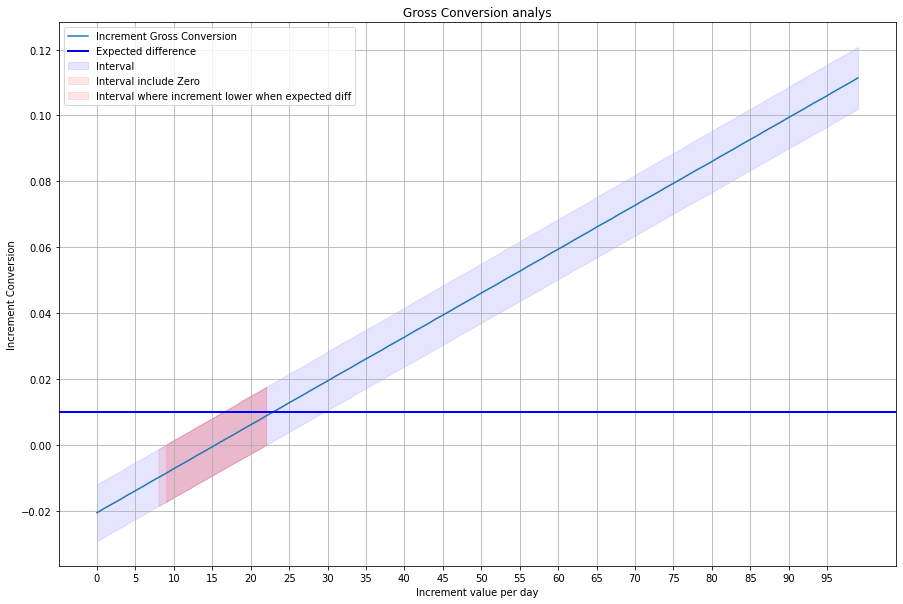

In [272]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (15, 10))
t = np.arange(0, T, h)
ax.plot(t, GC_res.T[2], label = 'Increment Gross Conversion')
indxs_bad = np.where((GC_res.T[0] <= 0) & (0 <= GC_res.T[1]))
indxs_conv = np.where(np.abs(GC_res.T[2]) < GC['d_min'] )
ax.set_xticks(np.arange(0, max(t), 5))
ax.set_ylabel('Increment Conversion')
ax.set_xlabel('Increment value per day')
ax.fill_between(t, GC_res.T[0], GC_res.T[1], alpha = .1, color = 'b', label = 'Interval')
ax.fill_between((np.array(indxs_bad) * h).tolist()[0], GC_res[indxs_bad].T[0], GC_res[indxs_bad].T[1], alpha = .1, color = 'r', label = 'Interval include Zero')
ax.fill_between((np.array(indxs_conv) * h).tolist()[0], GC_res[indxs_conv].T[0], GC_res[indxs_conv].T[1], alpha = .1, color = 'r', label = 'Interval where increment lower when expected diff')
ax.axhline(y=GC['d_min'], xmin=0, xmax=T, label = 'Expected difference', color = 'b', linewidth = 2)
ax.legend()
ax.set_title('Gross Conversion analys')
ax.grid('both')


Итак, исходя из графика можно сделать следующие выводы:
    <ul>
        <li> Для ожидаемого инкремента конверсии, в среднем ежедневно должно
            быть на 23 регистрации больше, чем есть в действительности
        </li>
         <li> Чтобы доверительный интервал изменения конверсии не содержал в себе 0, так же 
              в среднем ежедневно должно быть на 23 регистрации больше, чем есть в действительности
        </li>
    </ul>

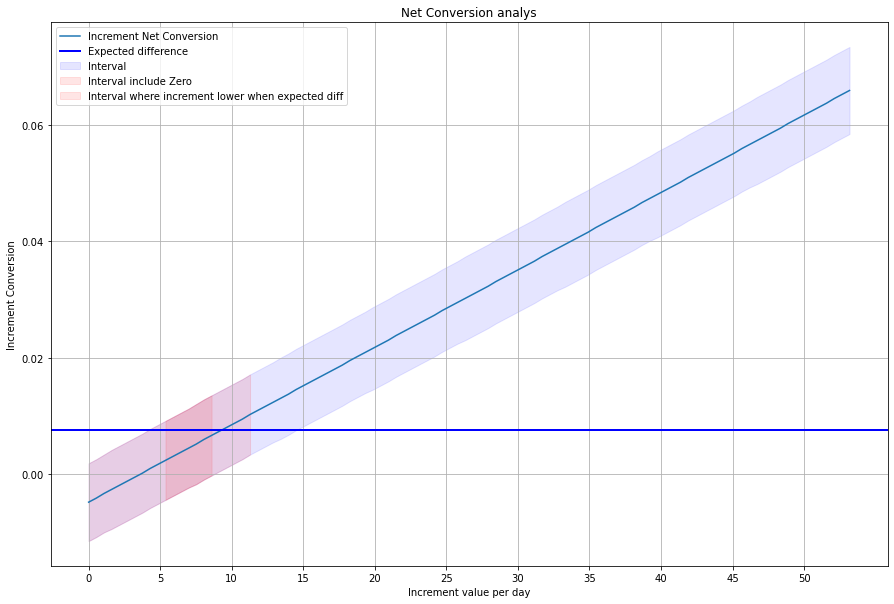

In [273]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (15, 10))
t = np.arange(0, T, h) * net_part
ax.plot(t, NC_res.T[2], label = 'Increment Net Conversion')
indxs_conv = np.where(np.abs(GC_res.T[2]) < NC['d_min'] )
indxs_bad = np.where((NC_res.T[0] <= 0) & (0 <= NC_res.T[1]))
ax.set_xticks(np.arange(0, max(t), 5))
ax.set_ylabel('Increment Conversion')
ax.set_xlabel('Increment value per day')
ax.fill_between(t, NC_res.T[0], NC_res.T[1], alpha = .1, color = 'b', label = 'Interval')
ax.fill_between((np.array(indxs_bad) * h* net_part).tolist()[0], NC_res[indxs_bad].T[0], NC_res[indxs_bad].T[1], alpha = .1, color = 'r', label = 'Interval include Zero')
ax.fill_between((np.array(indxs_conv) * h* net_part).tolist()[0], NC_res[indxs_conv].T[0], NC_res[indxs_conv].T[1], alpha = .1, color = 'r', label = 'Interval where increment lower when expected diff')
ax.axhline(y=NC['d_min'], xmin=0, xmax=T, label = 'Expected difference', color = 'b', linewidth = 2)
ax.legend()
ax.set_title('Net Conversion analys')
ax.grid('both')


Итак, исходя из графика можно сделать следующие выводы:
    <ul>
        <li> Для ожидаемого инкремента конверсии, в среднем ежедневно должно
            быть на 9 платежей больше, чем есть в действительности.
        </li>
         <li> Чтобы доверительный интервал изменения конверсии не содержал в себе 0, 
              в среднем ежедневно должно быть на 13 платежей больше, чем есть в действительности
        </li>
    </ul>
  
Так как доверительный интервал является здесь более строгим условием, то чтобы доверительный интервал изменения конверсии не содержал в себе 0 и выполнялось условие по практическому изменению конверсии
в среднем ежедневно должно быть на **13** платежей больше, чем есть в действительности

Далее рассмотрим **p-value** в зависимости от изменения.

Так как мы моделируем ситуацию, то не можем говорить, что конверсвия за день будет лучше или хуже с вероятностью 0.5.

В таком случае, для нахождения статистической значимости воспользуемся T - тестом.

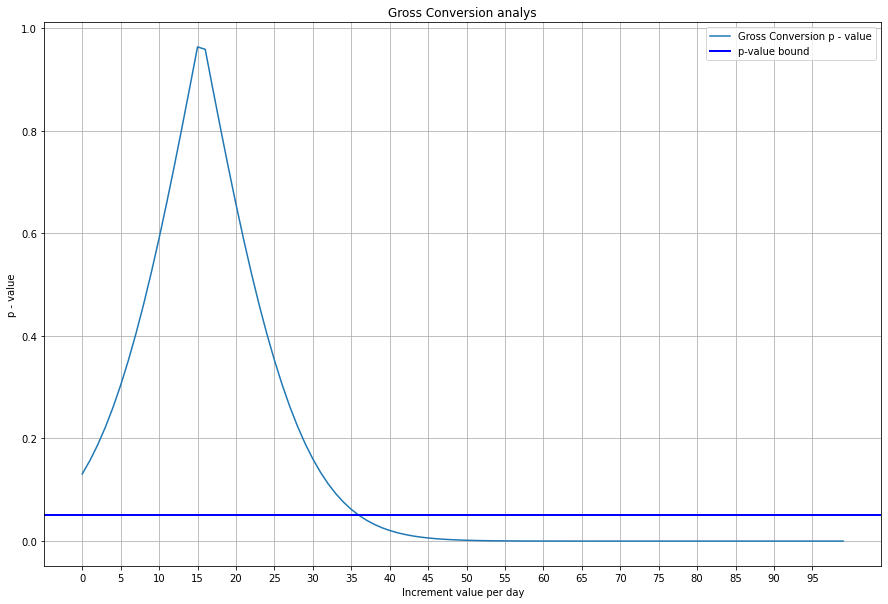

In [274]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (15, 10))
t = np.arange(0, T, h)
ax.plot(t, GC_res.T[3], label = 'Gross Conversion p - value')
ax.set_xticks(np.arange(0, max(t), 5))
ax.set_ylabel('p - value')
ax.set_xlabel('Increment value per day')
ax.axhline(y=0.05, xmin=0, xmax=T, label = 'p-value bound', color = 'b', linewidth = 2)
ax.legend()
ax.set_title('Gross Conversion analys')
ax.grid('both')


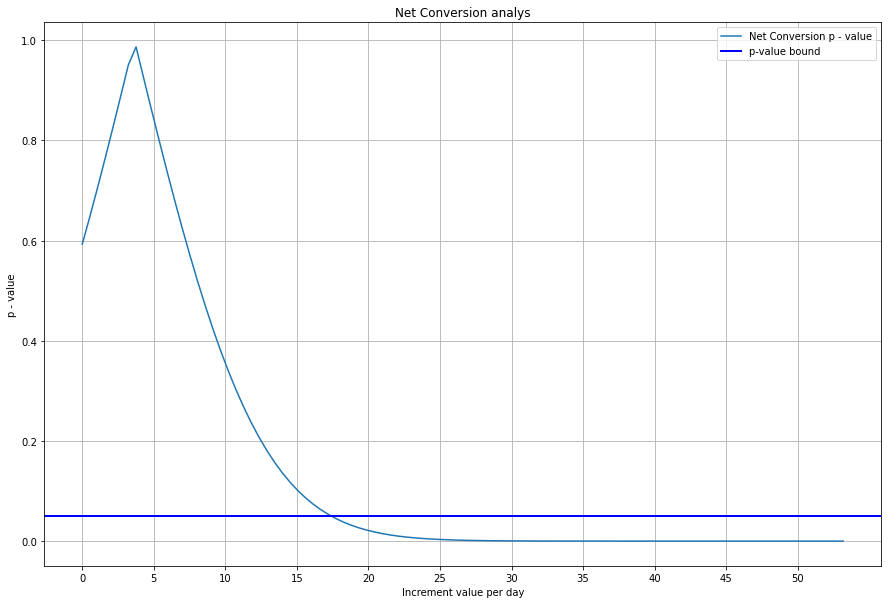

In [275]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (15, 10))
t = np.arange(0, T, h) * net_part
ax.plot(t, NC_res.T[3], label = 'Net Conversion p - value')
ax.set_xticks(np.arange(0, max(t), 5))
ax.set_ylabel('p - value')
ax.set_xlabel('Increment value per day')
ax.axhline(y=0.05, xmin=0, xmax=T, label = 'p-value bound', color = 'b', linewidth = 2)
ax.legend()
ax.set_title('Net Conversion analys')
ax.grid('both')


Итак, получается чтобы изменения **Gross Conversion** были статистически и практически значимы, а также результат был положительный, нужно чтобы ежедневных регистраций было на 40 больше. Что соответствует примерно 3% изменения конверсии.

В то время как для **Net Conversion** на 20 платежей больше. Что как раз пропорционально отношению **Payments** к **Enrollments** и соответствует примерно 2% изменения конверсии.

# Вывод анализа

<ul>
    <li>
        Чтобы Gross Conversion была статистически, практически значима и имела положительное изменение, 
        целевое действие должно быть ежедневно выше в среднем на 40 регистраций. Что будет соответсвовать изменению
        конверсии в 3% 
    </li>
    <li>
        Чтобы Net Conversion была статистически, практически значима и имела положительное изменение, 
        целевое действие должно быть ежедневно выше в среднем на 20 регистраций. Что будет соответсвовать изменению
        конверсии в 2% 
    </li>
    <li>
        Базовая аппроксимация  через биномиальное
        распределение для нахождения 
        статистической значимости дней с повышенной конверсией относительно контрольной группы, было ошибочно.
    </li>
</ul>